In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch, Data

import numpy as np
import matplotlib.pyplot as plt

from layers.ect import EctLayer
from layers.config import EctConfig


from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig



dataset = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))

for batch in dataset.train_dataloader():
    print(batch.x.shape)
    break

c:\Users\Ernst\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([10048, 2])


In [2]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
    ]
)


CONFIG = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,normalized=True,device=DEVICE)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = EctLayer(config = CONFIG,v=V)
        self.num_pts = NUM_PTS
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_THETAS**2,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512, 2*NUM_PTS) 
        )

    def forward(self, batch):
        _batch = batch.clone()
        _batch.ect = self.layer(_batch)
        _batch.x = self.encoder(_batch.ect).view(-1,2) 
        _batch.batch = torch.arange(batch.batch.max().item()+1,device=DEVICE).repeat_interleave(NUM_PTS)
        decoded = self.layer(_batch) 
        return decoded, _batch

In [4]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ectlayer = EctLayer(config = CONFIG, v=V)


In [5]:


# Point to training loop video
num_epochs = 20
for epoch in range(num_epochs):
    for batch in dataset.train_dataloader():
        batch = batch.to(DEVICE)
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon, _ = model(batch)
        batch_ect = ectlayer(batch) 
        loss = criterion(recon, batch_ect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')

Epoch:1, Loss:0.000279
Epoch:2, Loss:0.000277
Epoch:3, Loss:0.000169
Epoch:4, Loss:0.000131
Epoch:5, Loss:0.000142
Epoch:6, Loss:0.000132
Epoch:7, Loss:0.000127
Epoch:8, Loss:0.000118
Epoch:9, Loss:0.000170
Epoch:10, Loss:0.000110
Epoch:11, Loss:0.000100
Epoch:12, Loss:0.000138
Epoch:13, Loss:0.000107
Epoch:14, Loss:0.000106
Epoch:15, Loss:0.000103
Epoch:16, Loss:0.000098
Epoch:17, Loss:0.000096
Epoch:18, Loss:0.000101
Epoch:19, Loss:0.000094
Epoch:20, Loss:0.000098


In [6]:
for test_batch in dataset.test_dataloader():
    break

test_batch

DataBatch(x=[8689, 2], y=[64], batch=[8689], ptr=[65])

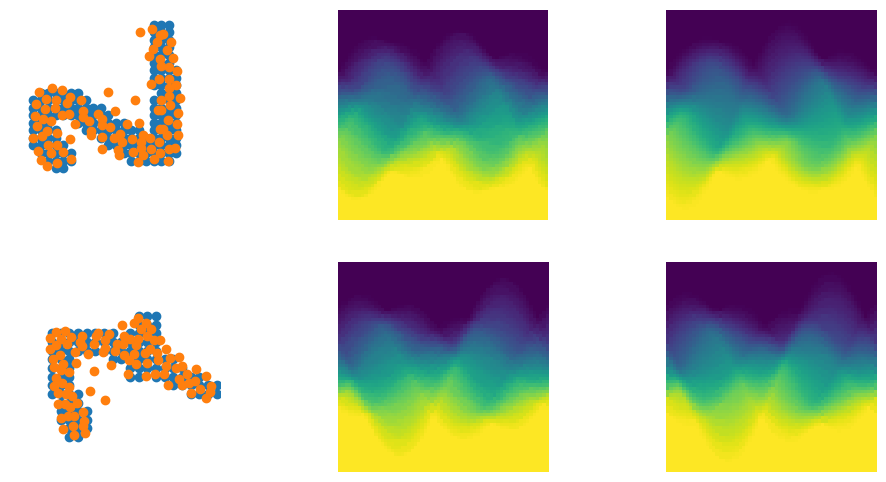

In [7]:


recon_batch, internal_batch = model(test_batch.to(DEVICE))


fig, axes = plt.subplots(2,3,figsize=(12,6))

for plt_idx,idx in enumerate([1,41]):
    pred = internal_batch.x[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS].cpu().detach().numpy()
    points = test_batch[idx].x.cpu().detach().numpy()

    # fig, axes = plt.subplots(nrows=2, ncols=2)
    # fig.suptitle(f"{test_batch[idx].y.item()}", fontsize=20)

    # Plot the point clouds
    ax = axes[plt_idx,0]
    ax.axis("off")
    ax.scatter(points[:,0],points[:,1])
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)

    # Plot the reconstructed ect
    ax = axes[plt_idx,1]
    ax.axis("off")
    ax.imshow(recon_batch[idx].cpu().squeeze().detach().numpy())

    # Plot the ect of the original
    ax = axes[plt_idx,2]
    ax.axis("off")
    ax.imshow(internal_batch.ect[idx].cpu().squeeze().detach().numpy())


# Sample from trained vae space

We load the trained variational autoencoder to generate new ect's and decode
them using our previously trained model. 


In [12]:
decoded = torch.load("decoded.pt")
ect = torch.load("ect.pt")
pointcloud = torch.load("features.pt")
decoded = (decoded + 1) / 2


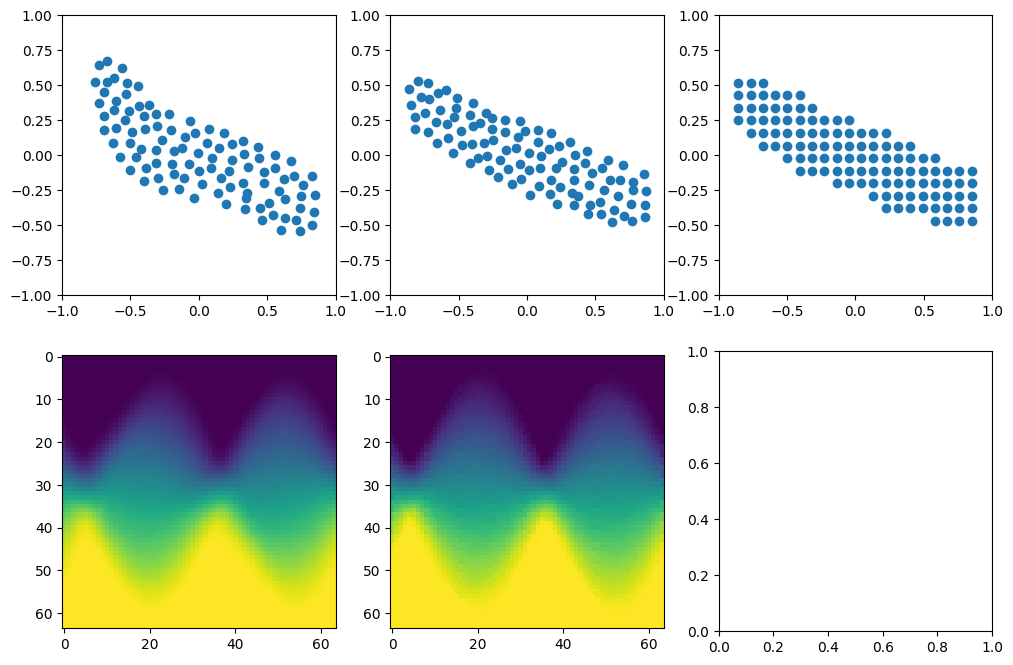

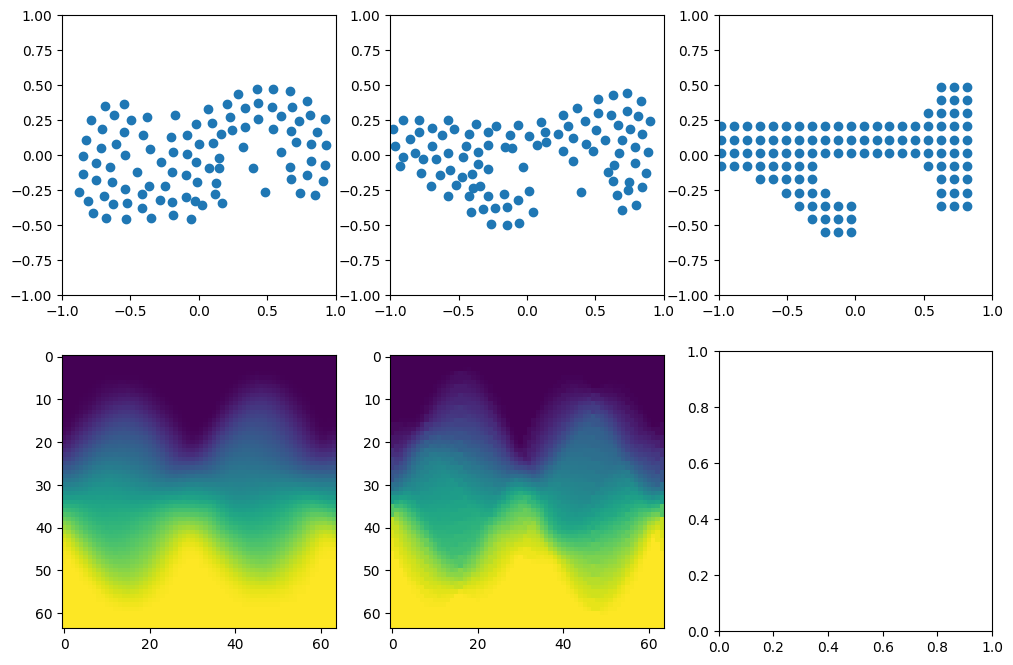

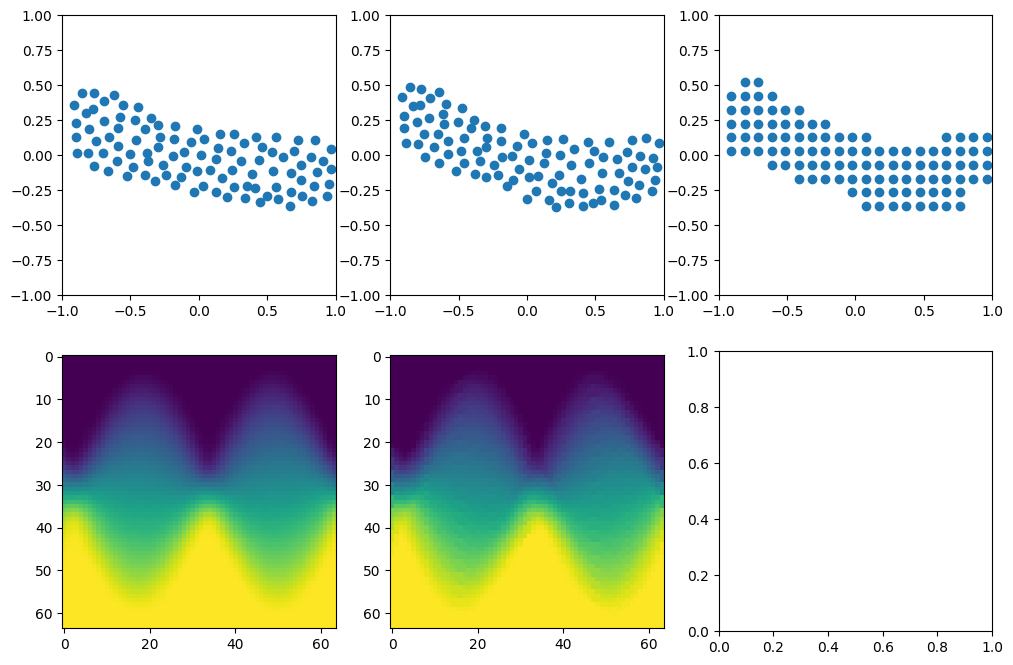

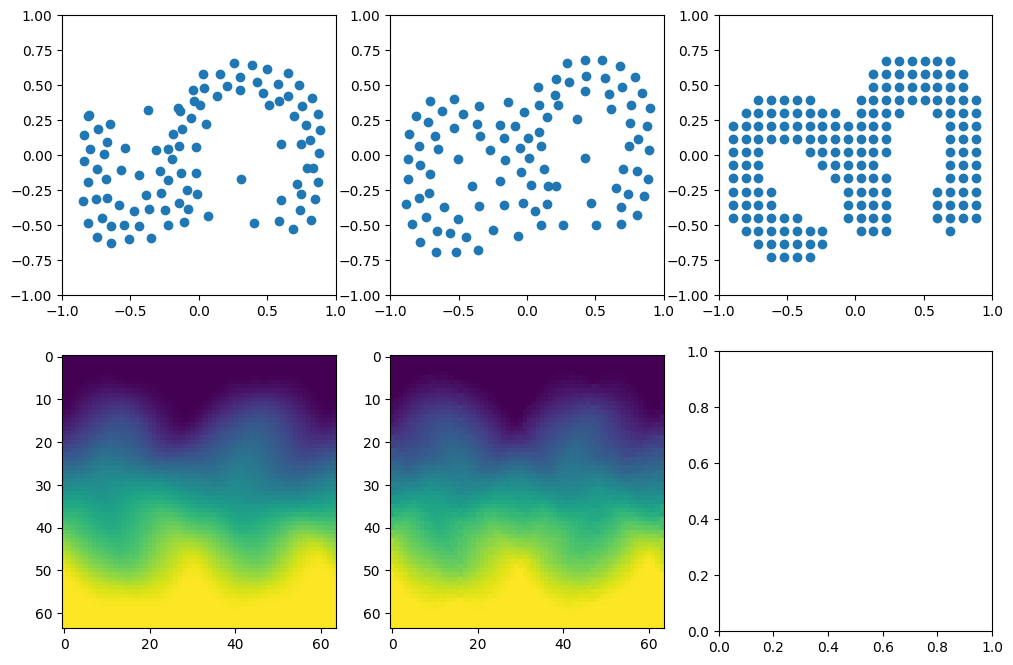

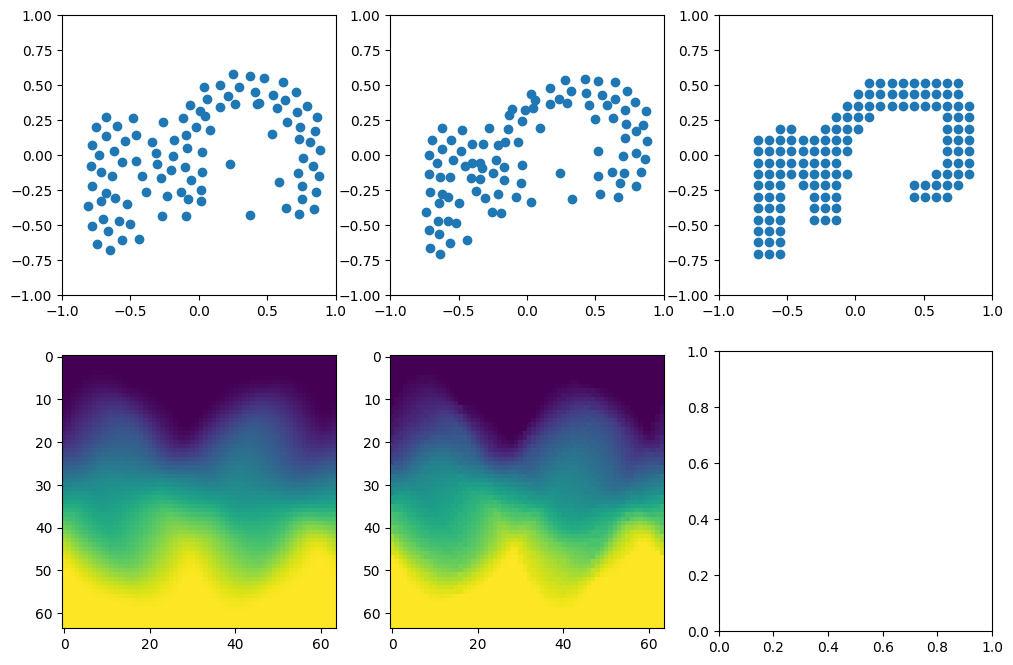

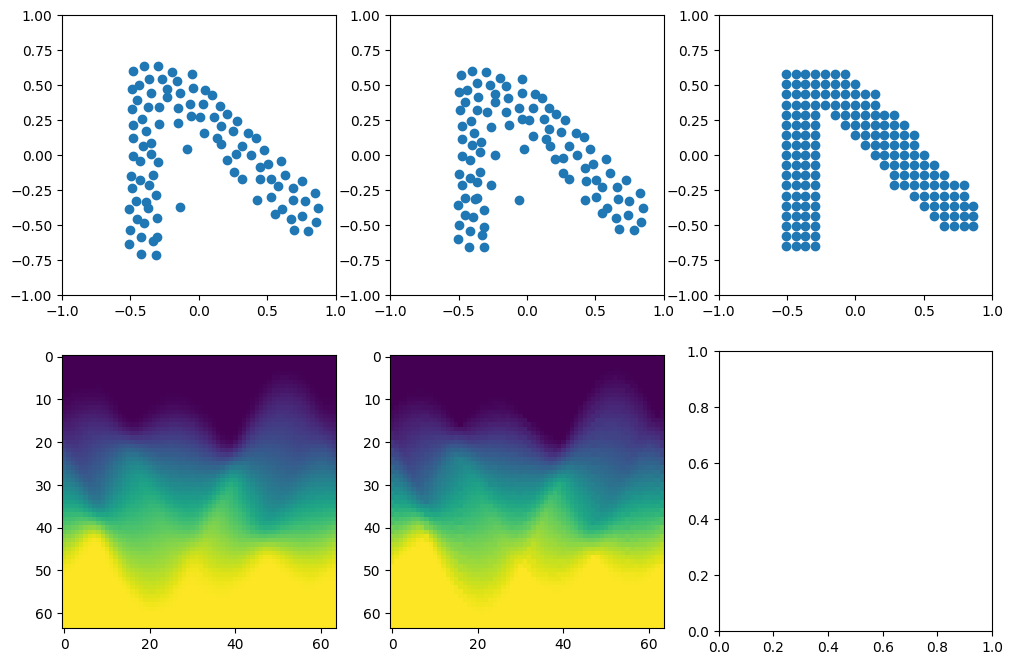

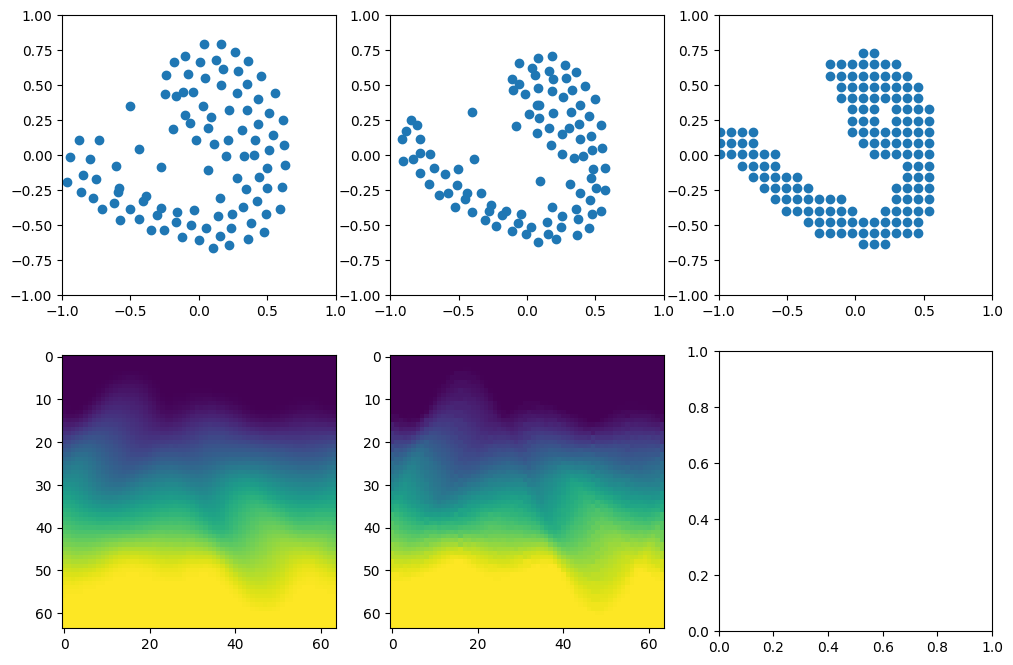

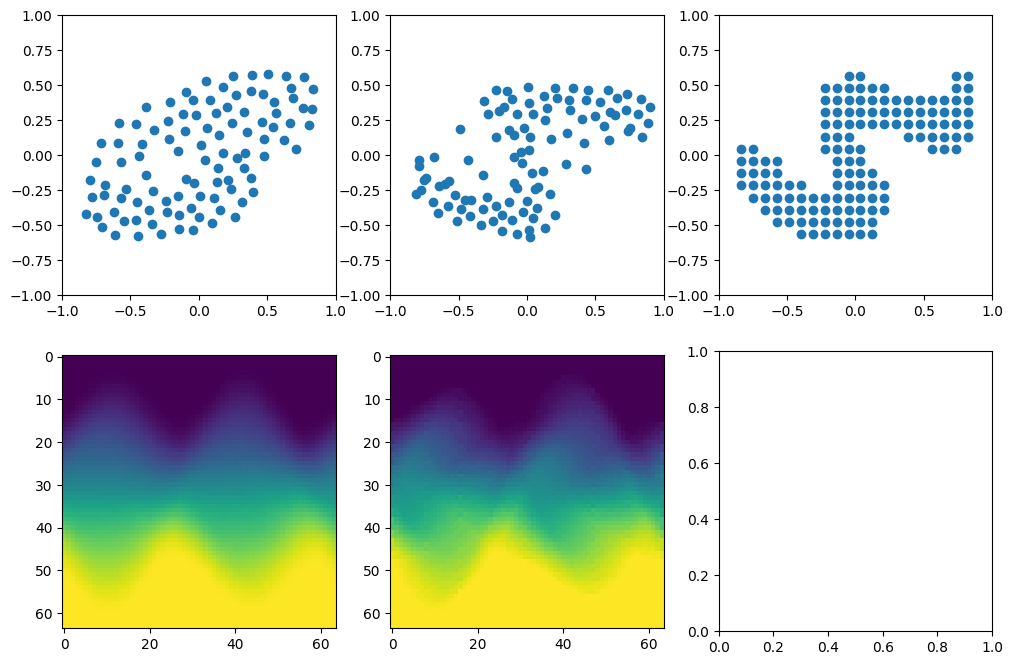

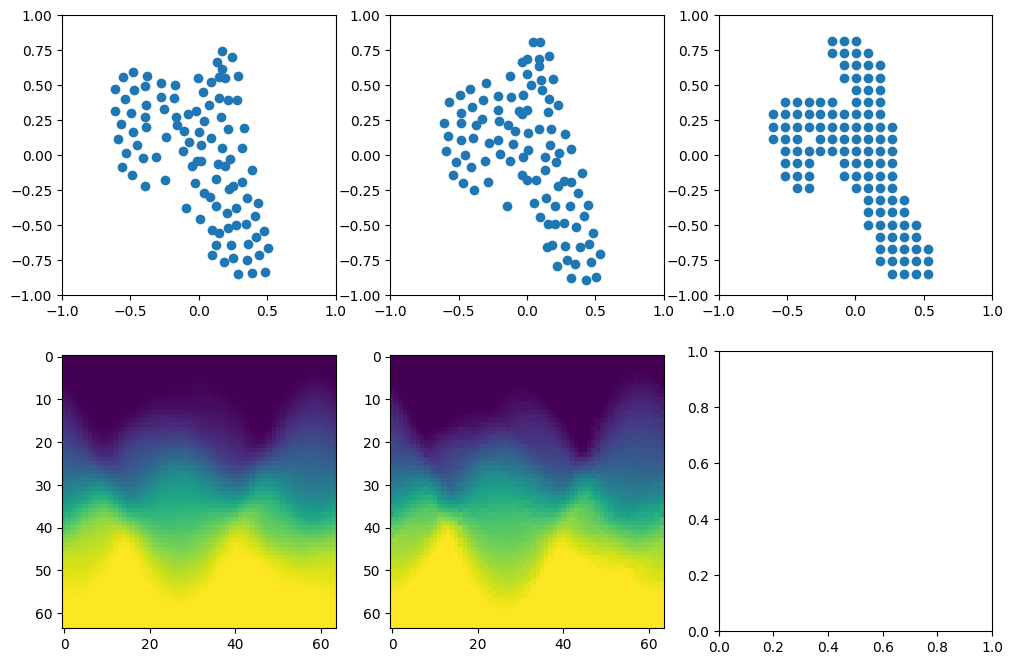

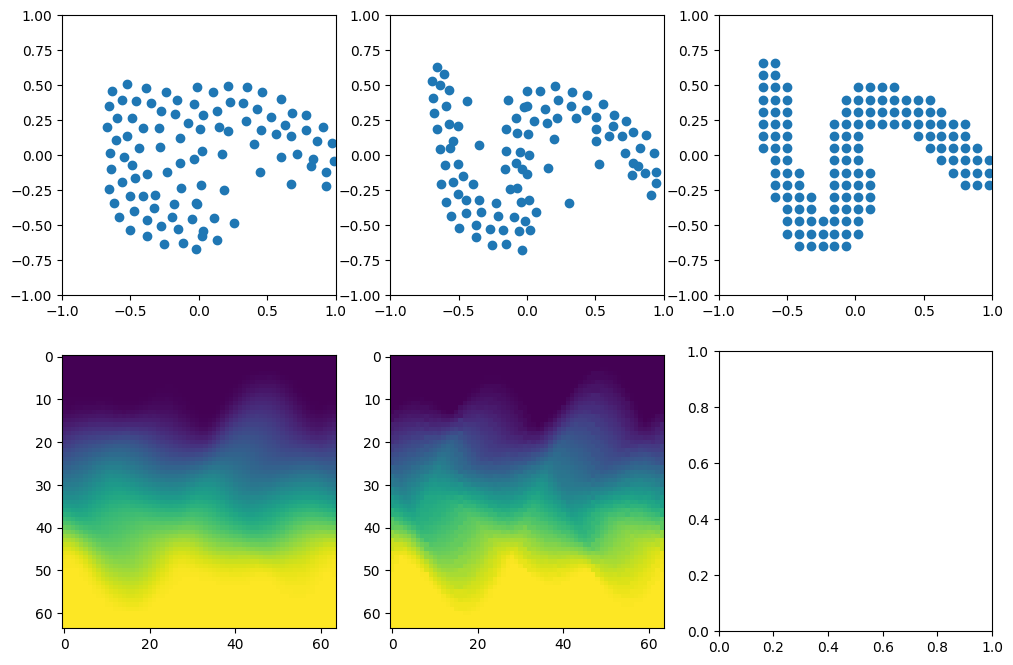

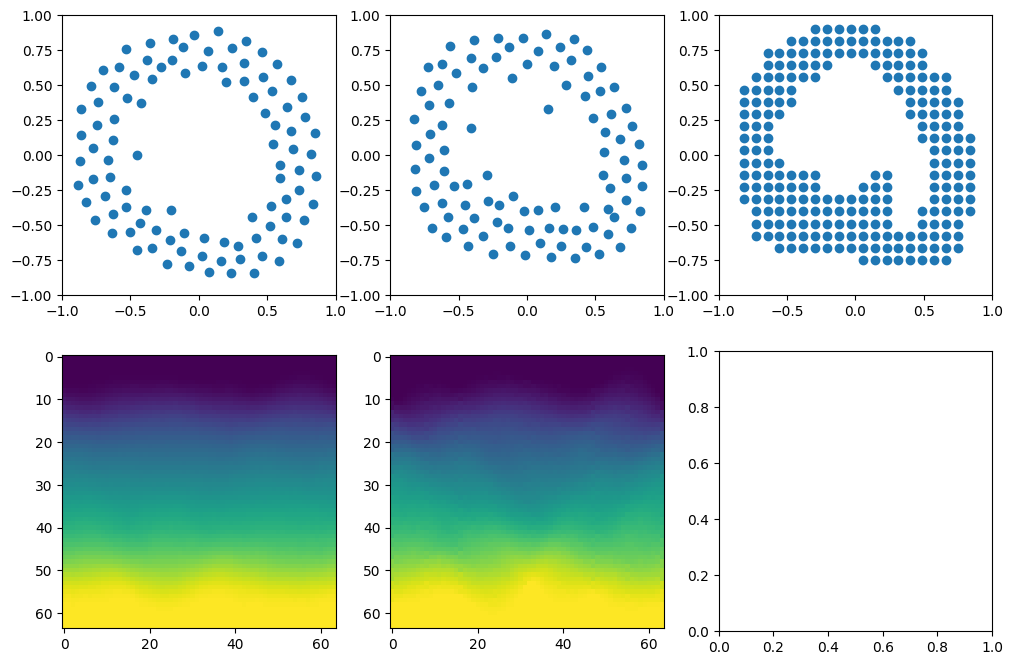

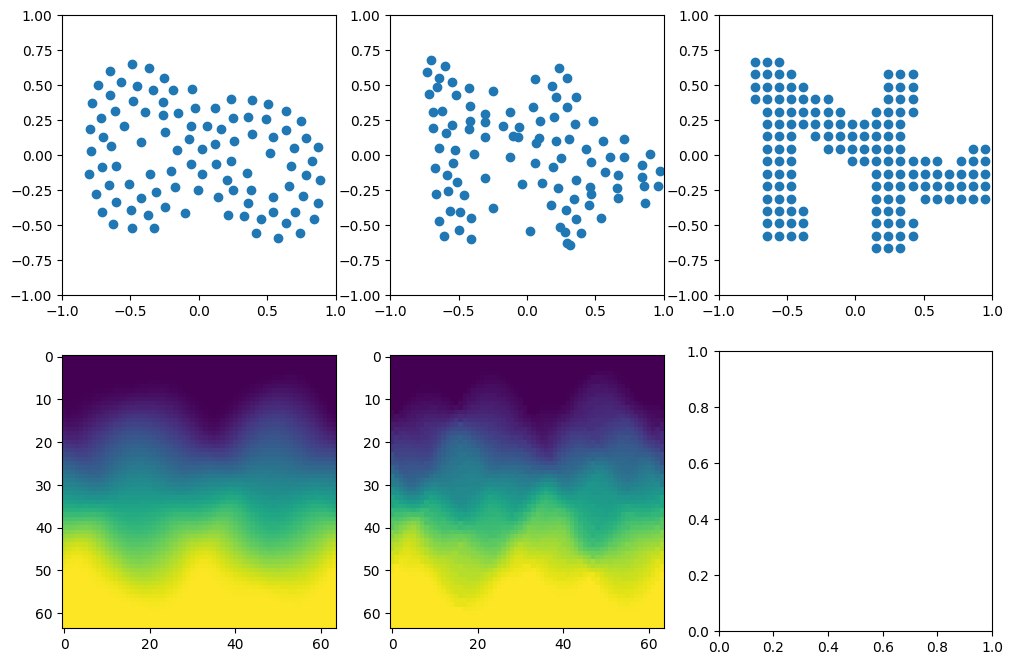

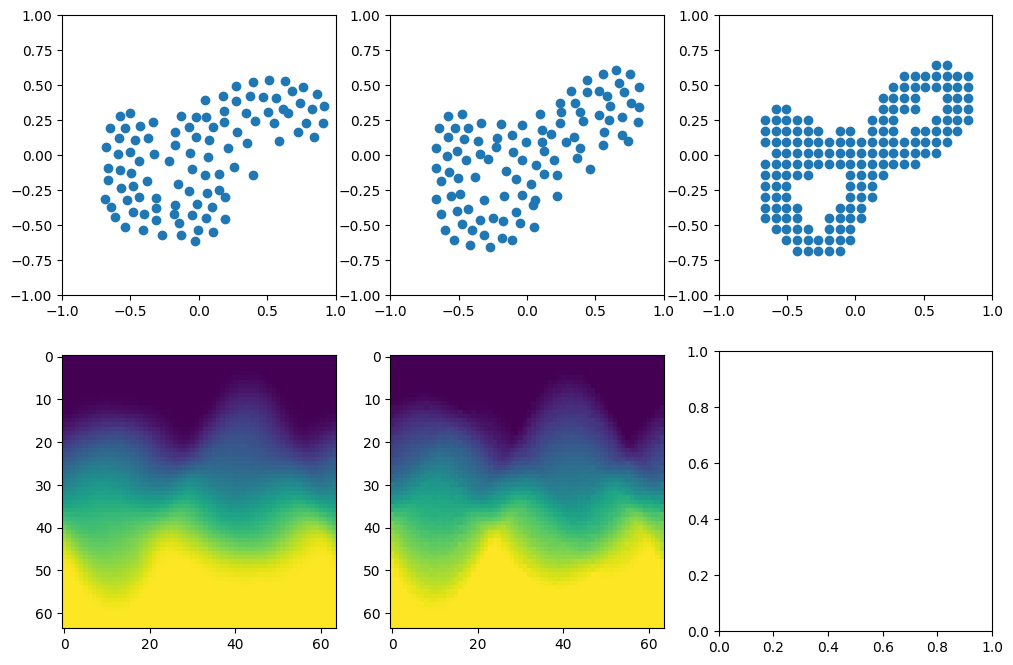

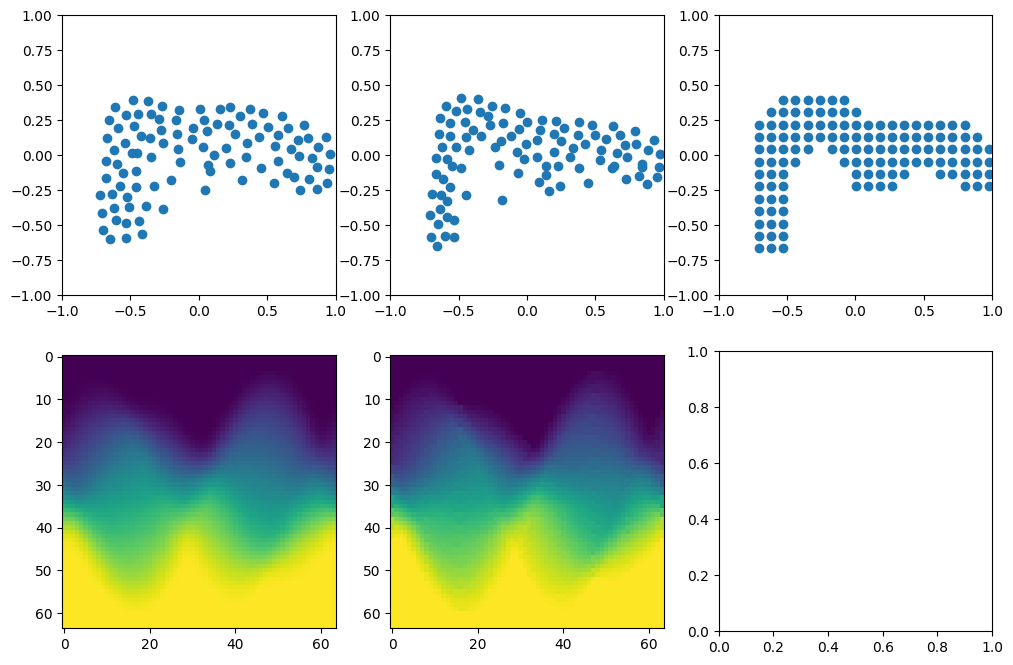

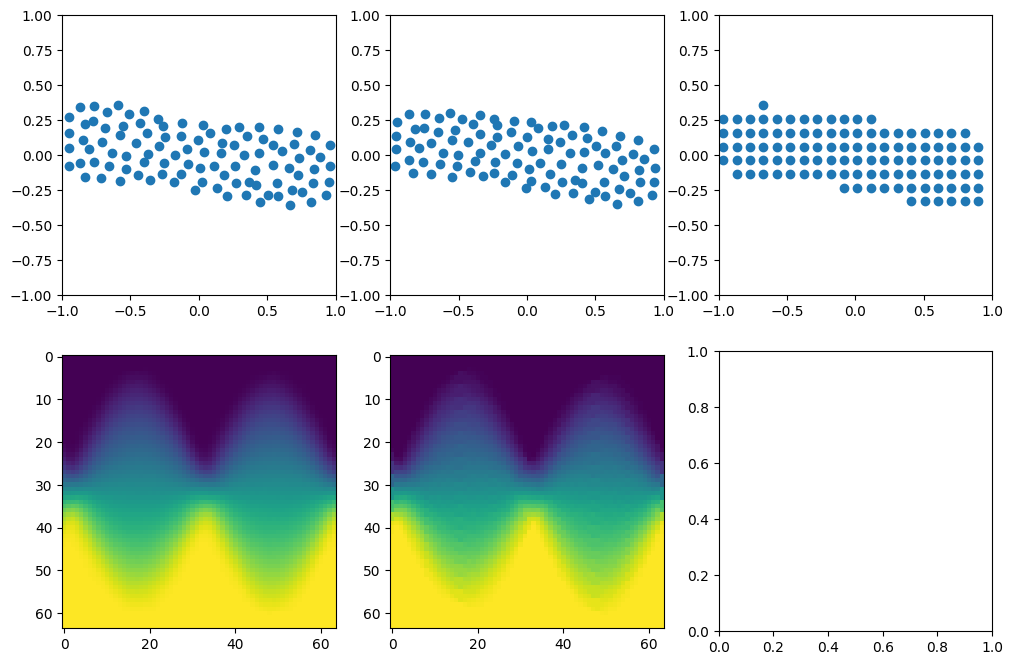

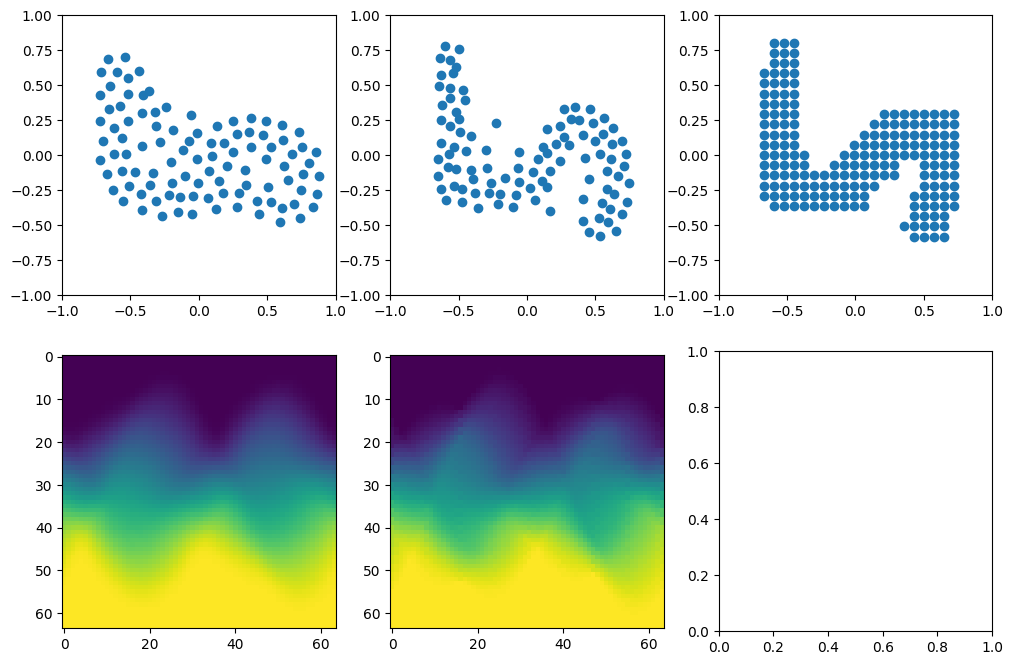

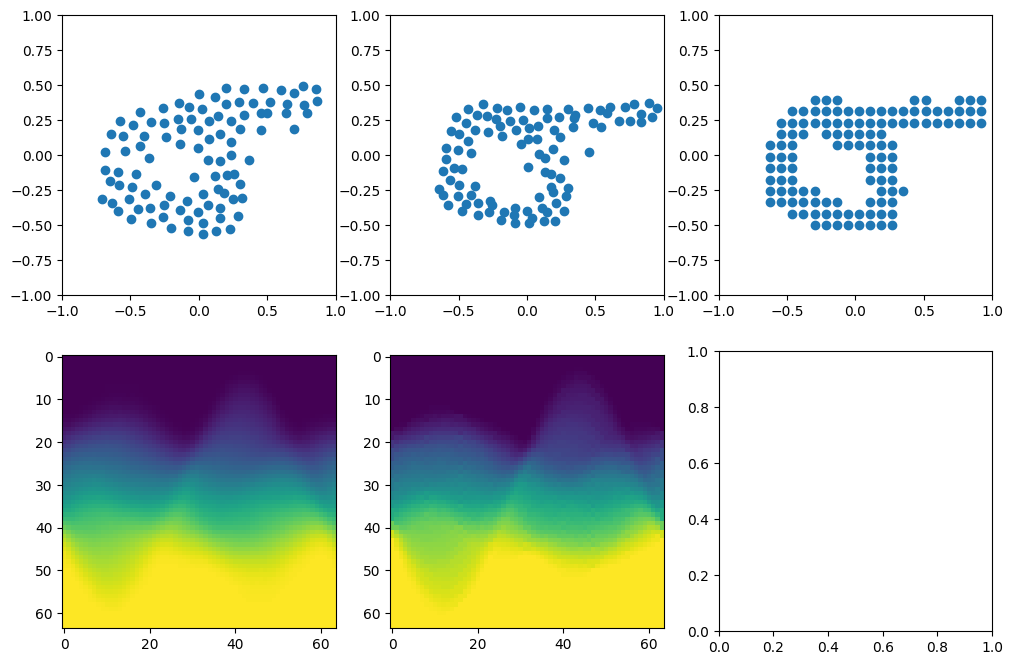

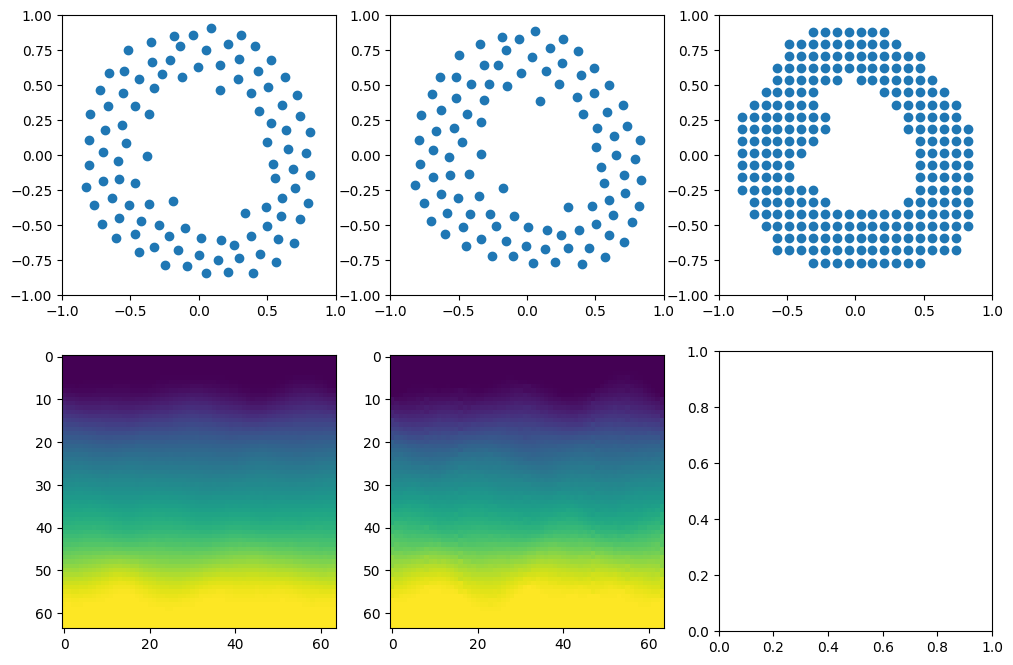

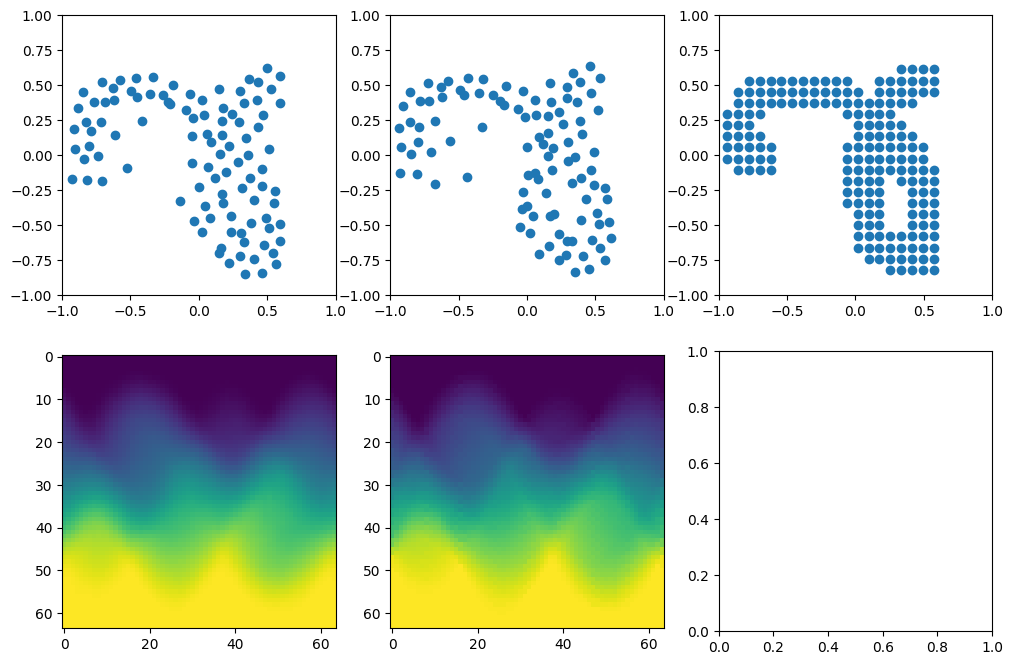

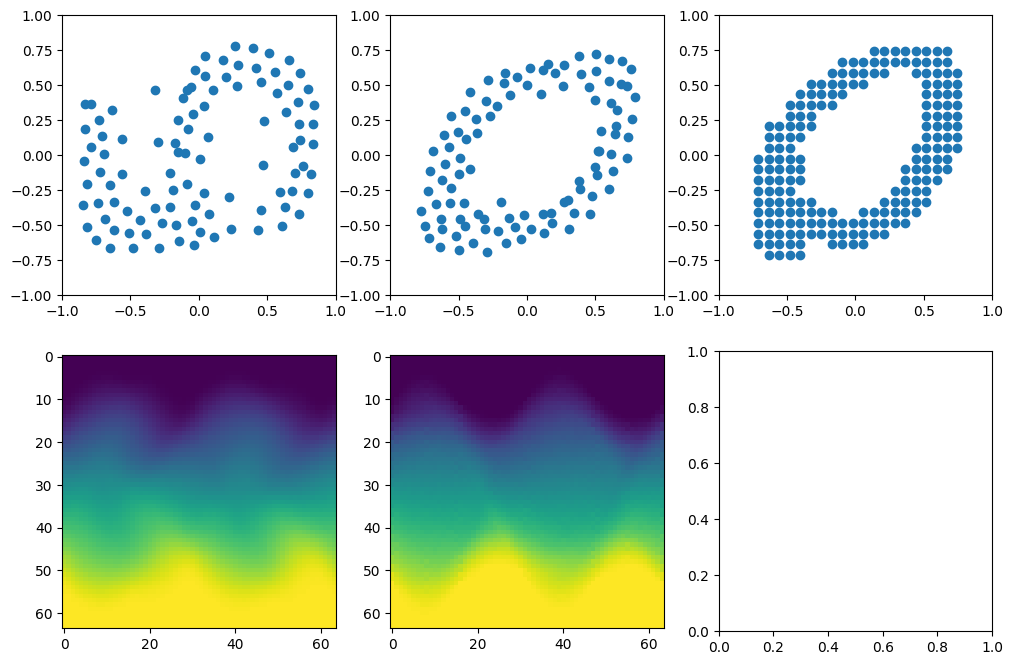

In [13]:


for idx in range(20):
    res_decoded = model.encoder(decoded).view(-1,100,2)[idx].cpu().detach().numpy()
    res_ect = model.encoder(ect).view(-1,100,2)[idx].cpu().detach().numpy()
    res_true = pointcloud[idx].x.cpu().detach().numpy()
    fig, axes = plt.subplots(2,3,figsize=(12,8))

    axes[0,0].scatter(res_decoded[:,0],res_decoded[:,1])
    axes[0,0].set_xlim([-1,1])
    axes[0,0].set_ylim([-1,1])

    axes[0,1].scatter(res_ect[:,0],res_ect[:,1])
    axes[0,1].set_xlim([-1,1])
    axes[0,1].set_ylim([-1,1])
    
    axes[0,2].scatter(res_true[:,0],res_true[:,1])
    axes[0,2].set_xlim([-1,1])
    axes[0,2].set_ylim([-1,1])


    axes[1,0].imshow(decoded[idx].squeeze().cpu().detach().numpy())
    axes[1,1].imshow(ect[idx].squeeze().cpu().detach().numpy())
    
    

### Sample from VAE


tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


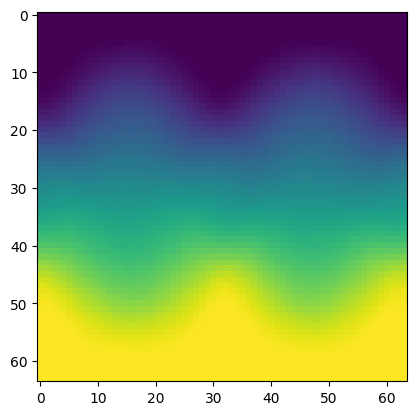

In [41]:

samples = torch.load("samples.pt")
samples = (samples + 1) / 2
print(samples.min())
print(samples.max())
plt.imshow(samples[4].squeeze().cpu().detach().numpy())


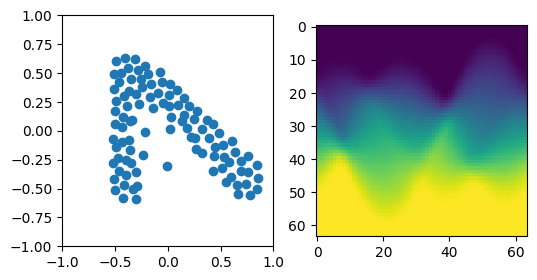

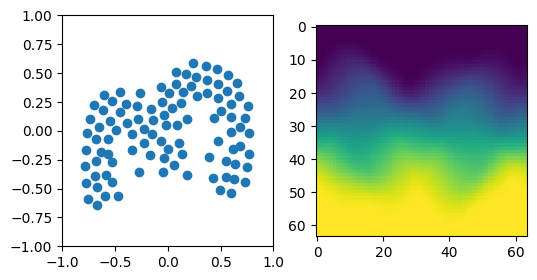

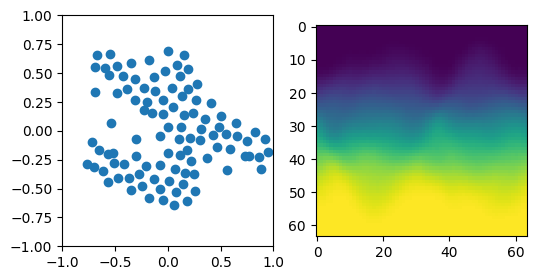

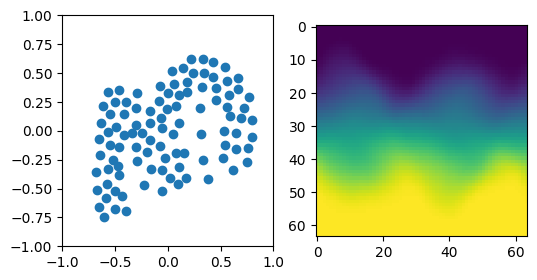

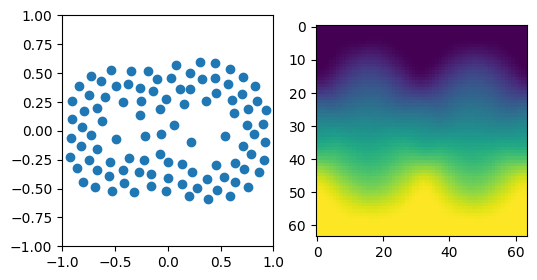

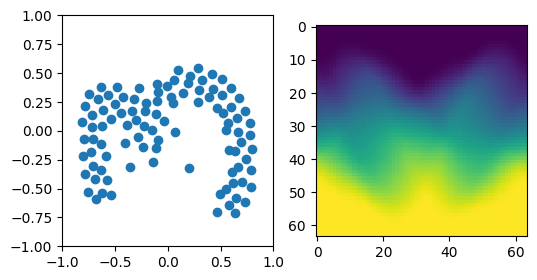

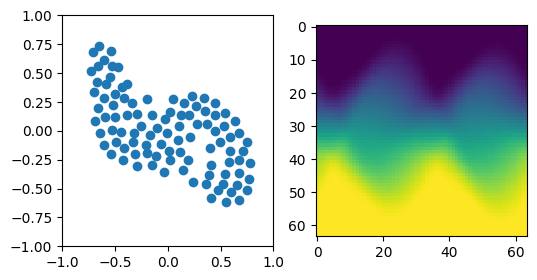

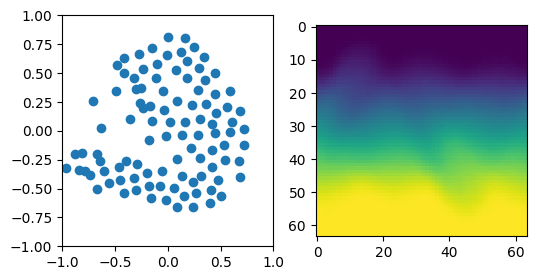

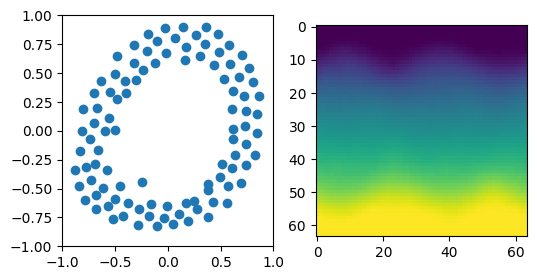

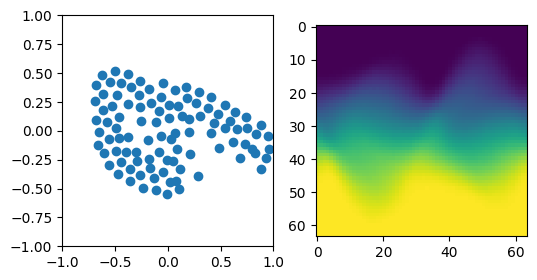

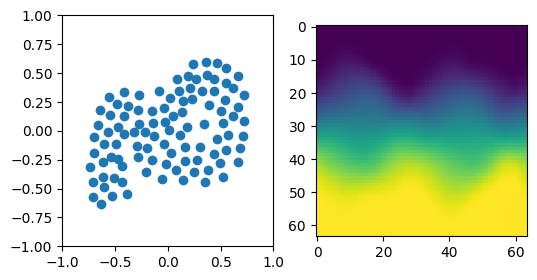

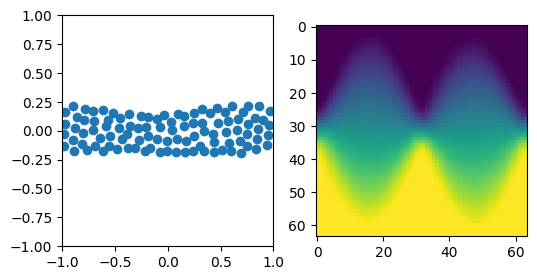

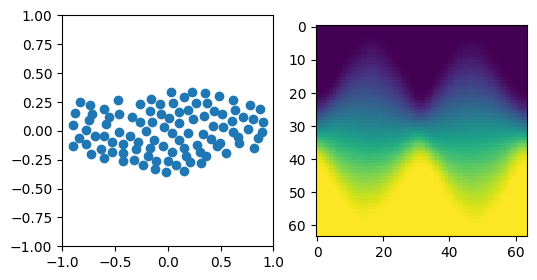

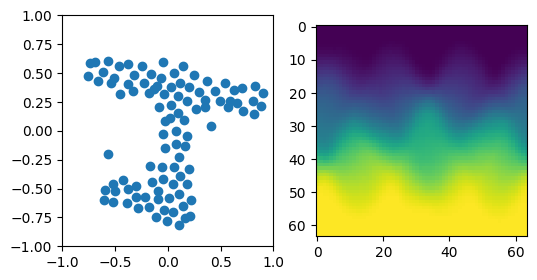

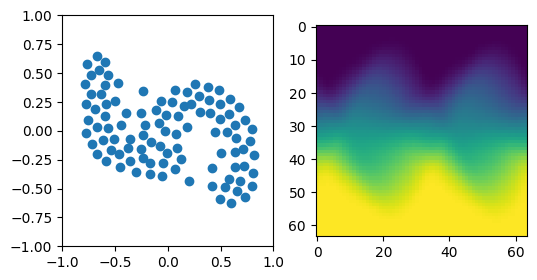

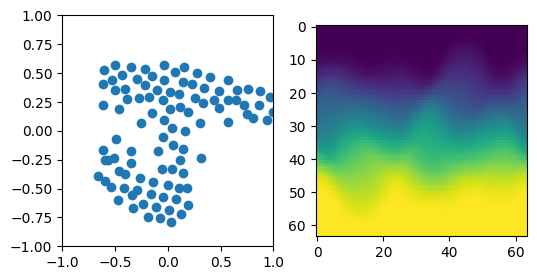

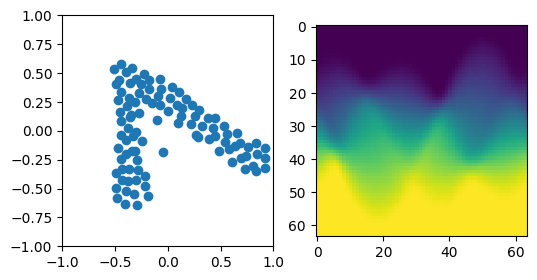

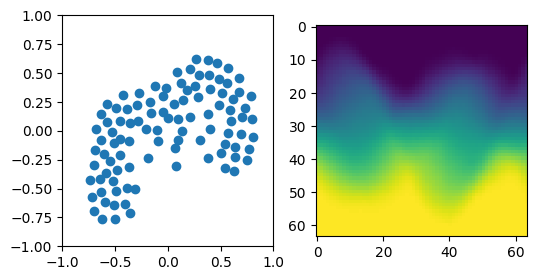

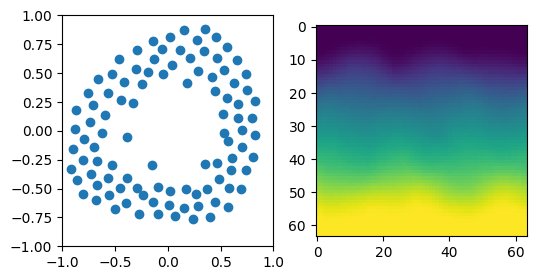

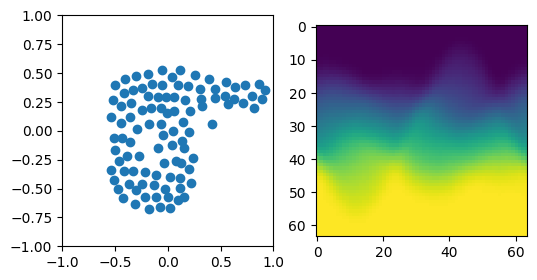

In [43]:

for idx in range(20):
    res_samples = model.encoder(samples).view(-1,100,2)[idx].cpu().detach().numpy()
    fig, axes = plt.subplots(1,2,figsize=(6,3))

    axes[0].scatter(res_samples[:,0],res_samples[:,1])
    axes[0].set_xlim([-1,1])
    axes[0].set_ylim([-1,1])

    axes[1].imshow(samples[idx].squeeze().cpu().detach().numpy())
